# LSN - simulation test code
* **Running things on compute canada (Graham)**

- Submit jobs: sbatch tf_test_job.sh

    #!/bin/bash
    #SBATCH --gres=gpu:1        # request GPU "generic resource"
    #SBATCH --cpus-per-task=6   # maximum CPU cores per GPU request: 6 on Cedar, 16 on Graham.
    #SBATCH --mem=32000M        # memory per node
    #SBATCH --account=def-mchakrav
    #SBATCH --time=0-00:05      # time (DD-HH:MM)
    #SBATCH --output=%N-%j.out  # %N for node name, %j for jobID

    module load cuda cudnn python/3.5.2
    module load scipy-stack/2018b
    source ../tensorflow/bin/activate
    python ./LSN_sim_testcode_3D.py
    
- Monitor jobs: squeue -u nikhil 
- Cancel jobs: scancel <jobid>

In [1]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import random
import time
import math
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime
from random import randint

# Main slim library
slim = tf.contrib.slim

# LSN Class and other functions

In [2]:
# Main slim library
slim = tf.contrib.slim

class siamese_net(object):
  
    def __init__(self, net_arch):
              
        self.input_L = tf.placeholder(tf.float32, [None, net_arch['input'],net_arch['input'],
                                                    net_arch['input']],name='baseline')        
        self.input_R = tf.placeholder(tf.float32, [None, net_arch['input'],net_arch['input'],
                                                    net_arch['input']],name='baseline')      
        self.labels = tf.placeholder(tf.float32, [None,net_arch['output']],name='trajectory')                
        self.is_training = True  #toggles dropout in slim
        self.dropout = 1      
                
        
        with tf.variable_scope("siamese") as scope:
            self.branch_L = self.convnet_slim(self.input_L, net_arch)
            scope.reuse_variables()
            self.branch_R = self.convnet_slim(self.input_R, net_arch)

        # Create metrics      
        self.distance = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(self.branch_L,self.branch_R),2),1))
            
        self.preds = self.get_predictions(net_arch)
        self.loss = self.get_loss()
        self.accuracy = self.get_accuracy()

    # Individual branch    
    def convnet_slim(self, X, net_arch):
        with slim.arg_scope([slim.conv3d], activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(net_arch['reg'])):

            # If needed, within the scope layer is made linear by setting activation_fn=None.
            # Creates a fully connected layers 
            for l in range(net_arch['n_layers']):
                net = slim.conv3d(X, net_arch['n_filters'], net_arch['filter_size'], normalizer_fn=slim.batch_norm,
                                  scope='fc{}'.format(l))
                net = slim.dropout(net, self.dropout, is_training=self.is_training)

            # MR output
            net = slim.flatten(net, scope='flatten3')
            MR_predictions = slim.fully_connected(net, net_arch['MR_output'], 
                                                  normalizer_fn=slim.batch_norm, scope='MR_prediction')               

            return MR_predictions #Later also return end_points 
    

    def get_predictions(self, net_arch):
        embed_vec = tf.concat([self.branch_L,self.branch_R],1,name='MR_embed_concat')            
        penult_predict = slim.fully_connected(embed_vec, net_arch['output'], activation_fn=tf.nn.softmax, 
                                               normalizer_fn=slim.batch_norm, scope='aux_prediction')
        return penult_predict

   
    # Set methods for class variables
    def set_dropout(self, dropout):
        self.dropout = dropout
      
    def set_train_mode(self,is_training):  
        self.is_training = is_training
      
    # Get methods for loss and acc metrics
    def get_loss(self):            
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels,logits=self.preds)) 

    def get_accuracy(self):
        correct_preds = tf.equal(tf.argmax(self.labels,1), tf.argmax(self.preds,1))
        return tf.reduce_mean(tf.cast(correct_preds, tf.float32)) 

    
# Other helper functions
def next_batch(s,e,mr_inputs,labels):
    input1 = mr_inputs[s:e,0]     
    input2 = mr_inputs[s:e,1]        
    y = labels[s:e]    
    return input1,input2,y
  
def check_data_shapes(data,net_arch):
    check = True  
    n_layers = net_arch['n_layers']
    if data['X_MR'].shape[1] != 2:
        print('wrong input data dimensions - need MR data for two branches')
        check = False
    elif data['X_MR'].shape[2] != net_arch['MR_shape']:
        print('input MR data <-> LSN arch mismatch')
        check = False
    elif data['X_aux'].shape[1] != net_arch['aux_shape']:
        print('input aux data <-> LSN arch mismatch')
        check = False
    elif data['y'].shape[1] != net_arch['output']:
        print('number of classes (2,3) <-> LSN arch mismatch')
        check = False
    else:
        for l in range(n_layers):
            try:
                _ = net_arch['l{}'.format(l+1)]
            except:
                print('Specify number of nodes for layer {}'.format(l))
                check = False        

    return check

In [3]:
# Train and test defs
def train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout, validate_after, verbose):
    valid_frac = int(0.1*len(data['y']))
    
    # Split into train and valid data for hyperparam tuning
    X_MR_train = data['X_MR'][:1-valid_frac]    
    y_train = data['y'][:1-valid_frac]

    X_MR_valid = data['X_MR'][1-valid_frac:]    
    y_valid = data['y'][1-valid_frac:]

    total_batch = int(len(y_train)/batch_size)
    #print('total_batch {}'.format(total_batch))
    
    train_acc_list = []
    valid_acc_list = []
    train_loss_list = []
    valid_loss_list = []
    
    # Training cycle
    for epoch in range(n_epochs):
        avg_loss = 0.
        avg_acc = 0.
        start_time = time.time()
        # Loop over all batches
        for i in range(total_batch):
            s  = i * batch_size
            e = (i+1) *batch_size

            # Fit training using batch data
            MR_L_batch,MR_R_batch,y_batch = next_batch(s,e,X_MR_train,y_train)

            # Train pass
            lsn.set_dropout(dropout)
            _,distance,preds,loss_value,acc_value=sess.run([optimizer,lsn.distance,lsn.preds,lsn.loss,lsn.accuracy], 
                                        feed_dict={lsn.input_L:MR_L_batch,
                                                   lsn.input_R:MR_R_batch,                                                   
                                                   lsn.labels:y_batch})                

            avg_loss += loss_value
            avg_acc +=acc_value*100

        duration = time.time() - start_time
        if verbose:
            print('epoch %d  time: %.2f loss %0.4f acc %0.2f' %(epoch,duration,avg_loss/total_batch,avg_acc/total_batch))      

        #Compute perf on entire training and validation sets (no need after every epoch)
        if epoch%validate_after == 0:
            train_acc = lsn.accuracy.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:],                                         
                                         lsn.labels:y_train})
            valid_acc = lsn.accuracy.eval(feed_dict={lsn.input_L:X_MR_valid[:,0,:],lsn.input_R:X_MR_valid[:,1,:],                                         
                                         lsn.labels:y_valid})
            train_loss = lsn.loss.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:],                                         
                                         lsn.labels:y_train})
            valid_loss = lsn.loss.eval(feed_dict={lsn.input_L:X_MR_valid[:,0,:],lsn.input_R:X_MR_valid[:,1,:],                                         
                                         lsn.labels:y_valid})
#             print('performance on entire train and valid subsets')
#             print('epoch {}\t train_acc:{}\t valid_acc:{}\n'.format(epoch,train_acc,valid_acc))
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
  
    # Post training: Compute preds and metrics for entire train data
    X_MR_train = data['X_MR']    
    y_train = data['y']
    train_feature_L = lsn.branch_L.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:]})
    train_feature_R = lsn.branch_R.eval(feed_dict={lsn.input_R:X_MR_train[:,1,:]})    
    train_distance = lsn.distance.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:]})
    train_preds= lsn.preds.eval(feed_dict={lsn.input_L:X_MR_train[:,0,:],lsn.input_R:X_MR_train[:,1,:]})

    train_metrics = {'train_feature_L':train_feature_L,'train_feature_R':train_feature_R,
                     'train_distance':train_distance,'train_preds':train_preds,
                     'train_loss':train_loss_list,'train_acc':train_acc_list,
                     'valid_loss':valid_loss_list,'valid_acc':valid_acc_list}

    return lsn, train_metrics

def test_lsn(sess,lsn,data):
    print('Testing model')    
    lsn.set_dropout(1)
    lsn.set_train_mode(False) 
    X_MR_test = data['X_MR']    
    y_test = data['y']
    #print(lsn.dropout)

    test_feature_L = lsn.branch_L.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:]})
    test_feature_R = lsn.branch_R.eval(feed_dict={lsn.input_R:X_MR_test[:,1,:]})
    test_distance = lsn.distance.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:],lsn.input_R:X_MR_test[:,1,:]})
    test_preds = lsn.preds.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:],lsn.input_R:X_MR_test[:,1,:]})
    test_acc = lsn.accuracy.eval(feed_dict={lsn.input_L:X_MR_test[:,0,:],lsn.input_R:X_MR_test[:,1,:],                                       
                                       lsn.labels:y_test})

    test_metrics = {'test_feature_L':test_feature_L,'test_feature_R':test_feature_R,
                    'test_distance':test_distance,'test_preds':test_preds,'test_acc':test_acc}
    print('Accuracy test set %0.2f' % (100 * test_acc))
    return lsn, test_metrics


# Generate simulation data 

# Simple random numbers with modulated mean

In [4]:
sampx = 1000
classes = 2
MR_size = 10

X_MR = np.random.rand(classes*sampx,MR_size,MR_size,MR_size)
y_cat = np.ones(sampx*classes)

# Modify feature distributions
for i in range(classes):
    X_MR[i*sampx:(i+1)*sampx] = X_MR[i*sampx:(i+1)*sampx]/(i+1)
    print('mean of i\'th subset {:4.2}'.format(np.mean(X_MR[i*sampx:(i+1)*sampx])))
    y_cat[i*sampx:(i+1)*sampx] = y_cat[i*sampx:(i+1)*sampx]*i
    
lb = LabelBinarizer()
y = lb.fit_transform(y_cat)

mean of i'th subset  0.5
mean of i'th subset 0.25


# Spatially varying boxes
* **Two possible variations**
    1. amplitude of the signal (i.e. box_signal)
    2. location of the signal (i.e. box offset)
    
    
* **timepoint modulator further scales the above variations** 
    1. Assumption: Small differnece between classes at baseline
    2. Assumption: Moderate spatially varying difference over timepoints between classes. 


* **Four MR distributions**
    1. BL+Class1: 
    2. BL+Class2: 
    3. Follow-up+Class1: 
    4. Follow-up+Class2: 

In [58]:
def generate_sim_data(sampx,classes,MR_size,delta_vars):
    
    # no-noise
    #X_MR = np.zeros((classes*sampx,MR_size,MR_size,MR_size))

    # Gaussian noise
    mu,st_dev = 0,.1
    X_MR = mu + st_dev * np.random.randn(classes*sampx,2,MR_size,MR_size,MR_size)

    # MR SNR
    box_signal = delta_vars['box_signal']

    # Size of feature / segmentation
    box_size_small = delta_vars['box_size_small']
    box_size_large = delta_vars['box_size_large']
    box_size_offset = 1 #Feature size differences between classes 

    # Modulators over classes and timepoints
    box_loc_class_offset = 1    # Spatial differences between classes    
    signal_class_modulator = delta_vars['signal_class_modulator']     # Intensity difference between classes
    signal_timepoint_modulator = delta_vars['signal_timepoint_modulator'] # temporal differences between classes

    # class1 (timepoint distributions need to be related)
    for s in range(sampx):
        box_size = randint(box_size_small,box_size_large)
        spatial_offset = MR_size - box_size

        # spatial offsets
        a,b,c = randint(0,spatial_offset),randint(0,spatial_offset),randint(0,spatial_offset)    

        # baseline
        X_box = box_signal*np.ones((1,box_size,box_size,box_size))
        X_MR[s,0,a:a+box_size,b:b+box_size,c:c+box_size] = X_box

        # follow-up           
        X_box = signal_timepoint_modulator*box_signal*np.ones((1,box_size,box_size,box_size))
        X_MR[s,1,a:a+box_size,b:b+box_size,c:c+box_size] = X_box

    # class2 (timepoint distributions need to be related)
    for s in range(sampx,2*sampx):
        box_size = randint(box_size_small,box_size_large) - box_size_offset
        spatial_offset = MR_size - box_size - box_loc_class_offset

        # spatial offsets
        a,b,c = int(randint(0,spatial_offset)),int(randint(0,spatial_offset)),int(randint(0,spatial_offset))    

        # baseline
        X_box = signal_class_modulator*box_signal*np.ones((1,box_size,box_size,box_size))    
        X_MR[s,0,a:a+box_size,b:b+box_size,c:c+box_size] = X_box

        # follow-up        
        X_box = signal_timepoint_modulator*signal_class_modulator*box_signal*np.ones((1,box_size,box_size,box_size))
        X_MR[s,1,a:a+box_size,b:b+box_size,c:c+box_size] = X_box


    print('baseline: class_1 avg volume {:4.1f}, class_2 avg volume {:4.1f}'.format(np.sum(X_MR[:sampx,0])/sampx,np.sum(X_MR[sampx:2*sampx,0])/sampx))
    print('')
    print('follow-up: class_1 avg volume {:4.1f}, class_2 avg volume {:4.1f}'.format(np.sum(X_MR[:sampx,1]/sampx),np.sum(X_MR[sampx:2*sampx,1])/sampx))
    print('')
    
    # Produce one-hot labels
    y = np.zeros((sampx*classes,2))
    y[:sampx,1]=np.ones(sampx)
    y[sampx:2*sampx,0]=np.ones(sampx)

    # Shuffle data before train-test split
    indx_shuff = np.arange(classes*sampx)
    np.random.shuffle(indx_shuff)
    X_MR = np.squeeze(X_MR[indx_shuff])
    y = np.squeeze(y[indx_shuff])

    # Train-test splits
    train_frac = int(0.9*(classes*sampx))
    X_MR_train = X_MR[:train_frac]
    y_train = y[:train_frac]

    X_MR_test = X_MR[train_frac:]
    y_test = y[train_frac:]
    subject_idx_test = indx_shuff[train_frac:]

#     print('shapes of X_MR_train:{}, y_train:{}, \n\t X_MR_test:{}, y_test:{}'.format(X_MR_train.shape,y_train.shape,
#                                                                                      X_MR_test.shape,y_test.shape)) 

    return X_MR_train, X_MR_test, y_train, y_test, subject_idx_test


# Train and test a sample LSN

In [59]:
def run_experiment(X_MR_train, X_MR_test, y_train, y_test, subject_idx_test): 
    # training params
    lr = 0.0001
    n_epochs = 40
    validate_after = int(n_epochs/5)
    batch_size = 100
    dropout = 1 #keep_prob
    verbose = False # Do you want to print perf after every epoch?? 
    save_model = False
    save_model_path = '/data/chamal/projects/nikhil/data/Traj_prediction/ADNI/exp_setup/TF_trained_models/'

    net_arch = {'input':MR_size,'n_filters':8,'filter_size':5,'n_layers':5,'MR_output':10,
                'output':classes,'reg':0.1}

    # minimal perf df --> append CV related attributes downstream. 
    perf_df = pd.DataFrame(columns=['subject_id','label','pred_prob','pred_label'])

    tf.reset_default_graph()
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:        
        # Train model    
        data = {'X_MR':X_MR_train,'y':y_train}    
        if True: #check_data_shapes(data,net_arch):      
            print('train data <-> net_arch check passed')   
            lsn = siamese_net(net_arch)                
            optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(lsn.loss)
            tf.global_variables_initializer().run()
            saver = tf.train.Saver()

            cur_time = datetime.time(datetime.now())
            print('\nStart training time: {}'.format(cur_time))                
            lsn, train_metrics = train_lsn(sess, lsn, data, optimizer, n_epochs, batch_size, dropout,
                                           validate_after,verbose)

            #Save trained model
            if save_model:
                print('saving model at {}'.format(save_model_path + 'lsn_example'))
                saver.save(sess, save_model_path + 'lsn_example')

            cur_time = datetime.time(datetime.now())
            print('End training time: {}\n'.format(cur_time))  

        else:
            print('train data <-> net_arch check failed')

        # Test model      
        data = {'X_MR':X_MR_test,'y':y_test}
        if True: #check_data_shapes(data,net_arch):
            print('test data <-> net_arch check passed')   
            _,test_metrics = test_lsn(sess,lsn,data)        
            # populate perf dataframe
            perf_df['subject_id']  = subject_idx_test
            perf_df['label'] = np.argmax(y_test,1)
            perf_df['pred_prob'] = list(test_metrics['test_preds'])
            perf_df['pred_label'] = np.argmax(test_metrics['test_preds'],1)
        else:
            print('test data <-> net_arch check failed')  
            
            
    return train_metrics, test_metrics, perf_df


In [60]:
from sklearn.grid_search import ParameterGrid
sampx = 2000
classes = 2
MR_size = 10

param_grid = {'box_signal': [10], 'box_size_small' : [4],'signal_class_modulator' : [1, 0.9, 0.5],
              'box_size_large': [5,6,7,8], 'signal_timepoint_modulator' : [1, 0.9, 0.5]}

grid = ParameterGrid(param_grid)

grid_df = pd.DataFrame(columns=['exp_idx','box_signal','box_size_small','box_size_large','signal_timepoint_modulator',
                                'signal_class_modulator', 'mean_train_distance','mean_test_distance','label',
                               'test_acc'])

idx = 0
 
cur_time = datetime.time(datetime.now())
print('\nStart experiment time: {}'.format(cur_time))       
for p, params in enumerate(grid):
    
    delta_vars = {'box_signal':params['box_signal'],'box_size_small':params['box_size_small'],
                  'box_size_large':params['box_size_large'],'signal_class_modulator':params['signal_class_modulator'],
                  'signal_timepoint_modulator':params['signal_timepoint_modulator']}

    X_MR_train, X_MR_test, y_train, y_test, subject_idx_test = generate_sim_data(sampx,classes,MR_size,delta_vars)
    train_metrics, test_metrics, perf_df = run_experiment(X_MR_train, X_MR_test, y_train, y_test, subject_idx_test)
    
    tr_d1 = np.mean(train_metrics['train_distance'][np.argmax(y_train,1)==0])    
    te_d1 = np.mean(test_metrics['test_distance'][np.argmax(y_test,1)==0])
    tr_d2 = np.mean(train_metrics['train_distance'][np.argmax(y_train,1)==1])
    te_d2 = np.mean(test_metrics['test_distance'][np.argmax(y_test,1)==1])
    
    grid_df.loc[idx] = [p,params['box_signal'],params['box_size_small'],params['box_size_large'],
                       params['signal_timepoint_modulator'],params['signal_class_modulator'],tr_d1,te_d1,0,test_metrics['test_acc'] ]
    idx+=1
    
    grid_df.loc[idx] = [p,params['box_signal'],params['box_size_small'],params['box_size_large'],
                       params['signal_timepoint_modulator'],params['signal_class_modulator'],tr_d2,te_d2,1,test_metrics['test_acc'] ]
    idx+=1
    
cur_time = datetime.time(datetime.now())
print('End experiment time: {}\n'.format(cur_time)) 
    


Start experiment time: 16:20:57.631083
baseline: class_1 avg volume 939.2, class_2 avg volume 944.9

follow-up: class_1 avg volume 939.2, class_2 avg volume 945.1

train data <-> net_arch check passed

Start training time: 16:20:58.443603
End training time: 16:21:03.478629

test data <-> net_arch check passed
Testing model
Accuracy test set 66.00
baseline: class_1 avg volume 948.9, class_2 avg volume 945.3

follow-up: class_1 avg volume 854.0, class_2 avg volume 850.7

train data <-> net_arch check passed

Start training time: 16:21:04.363014
End training time: 16:21:09.408454

test data <-> net_arch check passed
Testing model
Accuracy test set 69.25
baseline: class_1 avg volume 945.4, class_2 avg volume 942.9

follow-up: class_1 avg volume 472.7, class_2 avg volume 471.4

train data <-> net_arch check passed

Start training time: 16:21:10.161507
End training time: 16:21:15.172653

test data <-> net_arch check passed
Testing model
Accuracy test set 67.25
baseline: class_1 avg volume 9


Start training time: 16:23:30.792946
End training time: 16:23:35.815867

test data <-> net_arch check passed
Testing model
Accuracy test set 100.00
baseline: class_1 avg volume 2516.2, class_2 avg volume 2498.1

follow-up: class_1 avg volume 2516.1, class_2 avg volume 2498.0

train data <-> net_arch check passed

Start training time: 16:23:36.682215
End training time: 16:23:41.709332

test data <-> net_arch check passed
Testing model
Accuracy test set 66.00
baseline: class_1 avg volume 2509.6, class_2 avg volume 2519.1

follow-up: class_1 avg volume 2258.5, class_2 avg volume 2267.2

train data <-> net_arch check passed

Start training time: 16:23:42.598671
End training time: 16:23:47.627234

test data <-> net_arch check passed
Testing model
Accuracy test set 69.25
baseline: class_1 avg volume 2505.1, class_2 avg volume 2573.6

follow-up: class_1 avg volume 1252.5, class_2 avg volume 1286.8

train data <-> net_arch check passed

Start training time: 16:23:48.384486
End training time: 

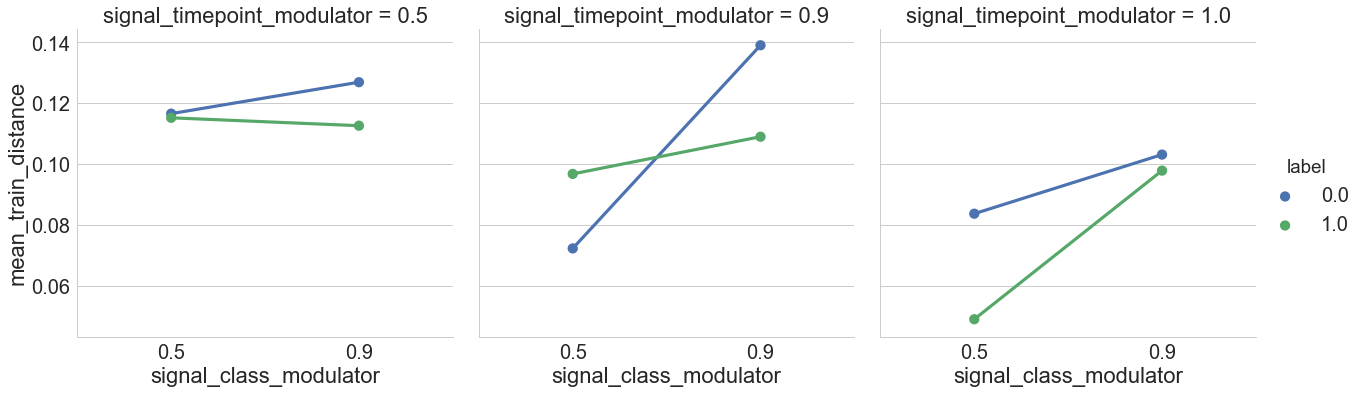

In [62]:
plot_df = grid_df[(grid_df['test_acc']>.8)&(grid_df['box_size_large']==8)]
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    sns.factorplot(x='signal_class_modulator',y='mean_train_distance',hue='label',kind='point',
                   col='signal_timepoint_modulator',data=plot_df,size=6,aspect=1)

In [51]:
plot_df

,exp_idx,box_signal,box_size_small,box_size_large,signal_timepoint_modulator,signal_class_modulator,mean_train_distance,mean_test_distance,label,test_acc
6,3.0,10.0,4.0,5.0,1.0,0.9,0.126288,0.132283,0.0,0.8975
7,3.0,10.0,4.0,5.0,1.0,0.9,0.130955,0.129909,1.0,0.8975
8,4.0,10.0,4.0,5.0,0.9,0.9,0.101739,0.106518,0.0,0.8500
9,4.0,10.0,4.0,5.0,0.9,0.9,0.110807,0.111241,1.0,0.8500
10,5.0,10.0,4.0,5.0,0.5,0.9,0.244191,0.239399,0.0,0.9725
11,5.0,10.0,4.0,5.0,0.5,0.9,0.278161,0.284667,1.0,0.9725
12,6.0,10.0,4.0,5.0,1.0,0.5,0.125439,0.126253,0.0,1.0000
13,6.0,10.0,4.0,5.0,1.0,0.5,0.114915,0.117436,1.0,1.0000
14,7.0,10.0,4.0,5.0,0.9,0.5,0.133948,0.129327,0.0,1.0000
15,7.0,10.0,4.0,5.0,0.9,0.5,0.091798,0.087332,1.0,1.0000


# Restore dave TF session with pretrained model

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [10]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(save_model_path + 'lsn_example.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint(save_model_path))
    _,test_metrics = test_lsn(sess,lsn,data) 
    

INFO:tensorflow:Restoring parameters from /data/chamal/projects/nikhil/data/Traj_prediction/ADNI/exp_setup/TF_trained_models/lsn_example
Testing model
Accuracy test set 99.20


# Plots

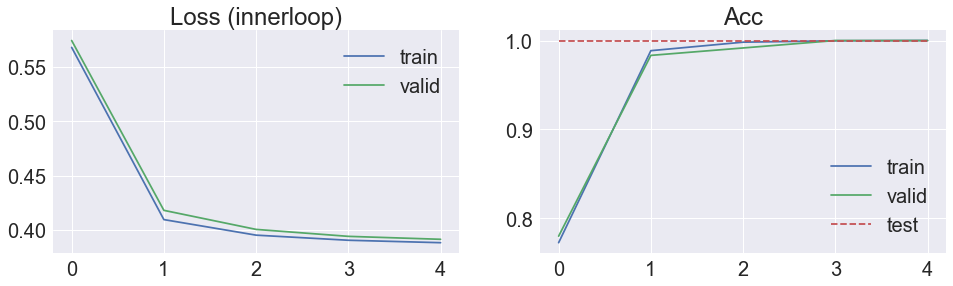

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

plt.figure(figsize=(16,9))
plt.style.use('seaborn-white')
sns.set(font_scale=2)
train_loss = train_metrics['train_loss']
valid_loss = train_metrics['valid_loss']
train_acc = train_metrics['train_acc']
valid_acc = train_metrics['valid_acc']

plt.subplot(2,2,1)
plt.plot(train_loss,label='train');
plt.plot(valid_loss,label='valid');
plt.title('Loss (innerloop)')
# plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_acc,label='train');
plt.plot(valid_acc,label='valid');
plt.plot(np.tile(test_metrics['test_acc'],len(train_acc)),'--',label='test')
plt.title('Acc')
# plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()

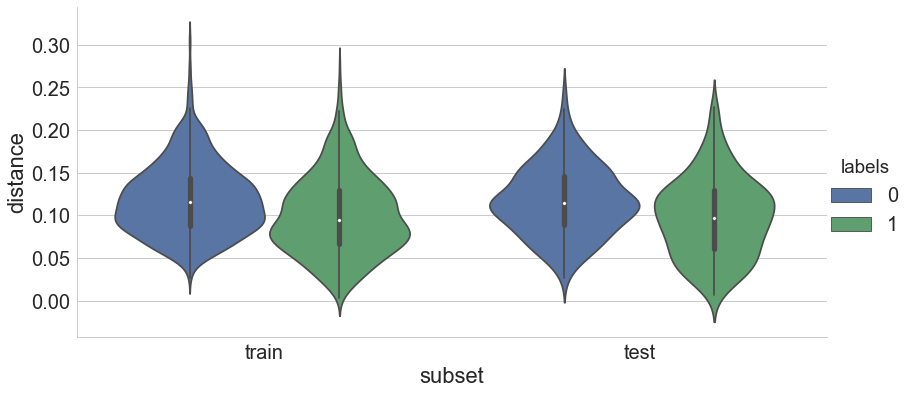

In [56]:
# Plot distance distributions
train_df = pd.DataFrame(columns=['distance','labels','subset'])
test_df = pd.DataFrame(columns=['distance','labels','subset'])
train_df['distance'] = train_metrics['train_distance']
train_df['labels'] = np.argmax(y_train,1)
train_df['subset'] = np.tile('train',len(y_train))
test_df['distance'] = test_metrics['test_distance']
test_df['labels'] = np.argmax(y_test,1)
test_df['subset'] = np.tile('test',len(y_test))
plot_df = train_df.append(test_df)
with sns.axes_style("whitegrid"):
    sns.factorplot(x='subset',y='distance',hue='labels',kind='violin',
                   data=plot_df,size=6,aspect=2)

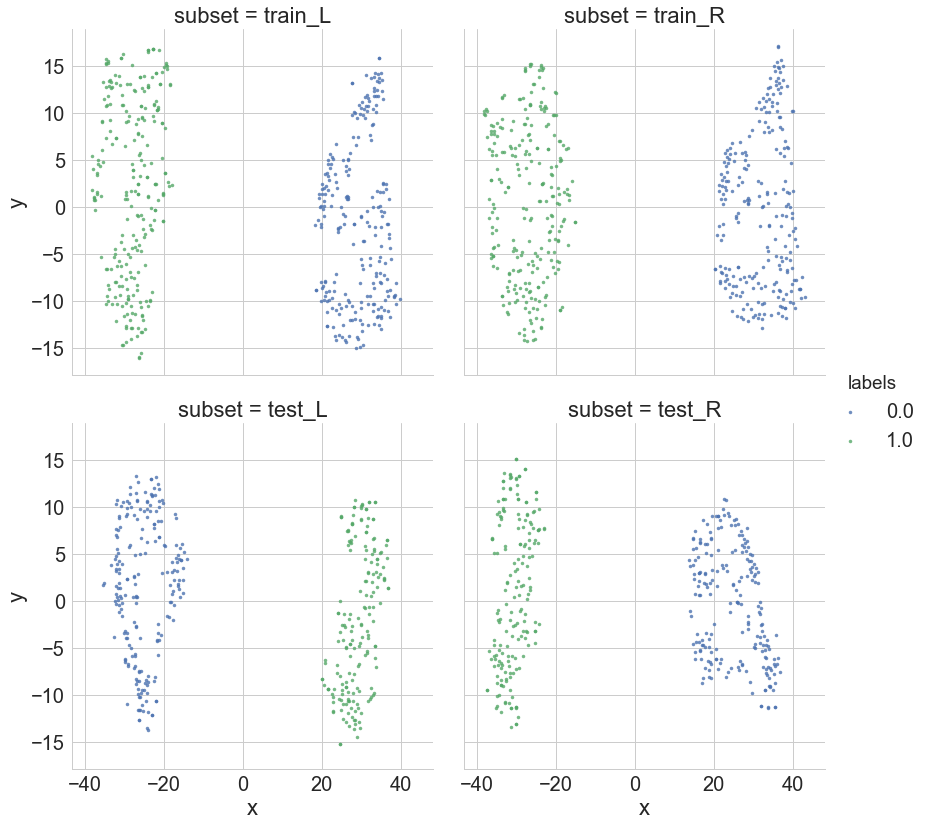

In [57]:
#Plot TSNE
tsne_sampx = 500 #Too slow for large number of samples
train_embed_L = train_metrics['train_feature_L']
train_embed_R = train_metrics['train_feature_R']

test_embed_L = test_metrics['test_feature_L']
test_embed_R = test_metrics['test_feature_R']

train_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(train_embed_L[:tsne_sampx])
test_tsne_embed_L = TSNE(n_components=2,init='pca').fit_transform(test_embed_L[:tsne_sampx])
train_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(train_embed_R[:tsne_sampx])
test_tsne_embed_R = TSNE(n_components=2,init='pca').fit_transform(test_embed_R[:tsne_sampx])


train_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_L = pd.DataFrame(columns=['x','y','labels','subset'])
train_df_R = pd.DataFrame(columns=['x','y','labels','subset'])
test_df_R = pd.DataFrame(columns=['x','y','labels','subset'])

train_df_L['x'] = train_tsne_embed_L[:,0] 
train_df_L['y'] = train_tsne_embed_L[:,1] 
train_df_L['labels'] = y_train[:tsne_sampx]
train_df_L['subset'] = np.tile('train_L',len(y_train[:tsne_sampx]))

train_df_R['x'] = train_tsne_embed_R[:,0] 
train_df_R['y'] = train_tsne_embed_R[:,1] 
train_df_R['labels'] = y_train[:tsne_sampx]
train_df_R['subset'] = np.tile('train_R',len(y_train[:tsne_sampx]))

test_df_L['x'] = test_tsne_embed_L[:,0] 
test_df_L['y'] = test_tsne_embed_L[:,1] 
test_df_L['labels'] = y_test[:tsne_sampx]
test_df_L['subset'] = np.tile('test_L',len(y_test[:tsne_sampx]))

test_df_R['x'] = test_tsne_embed_R[:,0] 
test_df_R['y'] = test_tsne_embed_R[:,1] 
test_df_R['labels'] = y_test[:tsne_sampx]
test_df_R['subset'] = np.tile('test_R',len(y_test[:tsne_sampx]))

with sns.axes_style("whitegrid"):
    plot_df = train_df_L.append(train_df_R).append(test_df_L).append(test_df_R)
    sns.lmplot(x='x',y='y',hue='labels',col='subset',col_wrap=2, 
               fit_reg=False, markers='.',data=plot_df,size=6);


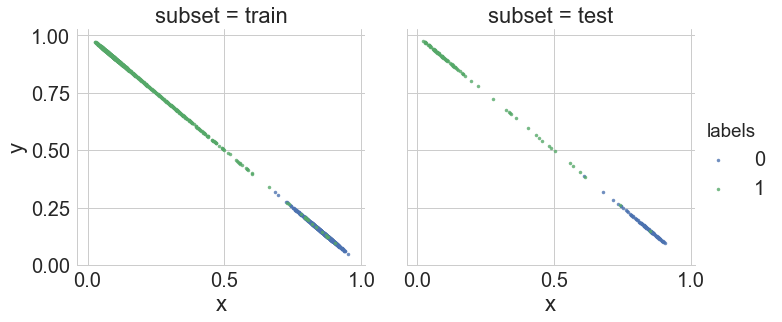

In [293]:
# Plot preds
train_features = train_metrics['train_preds']
test_features = test_metrics['test_preds']

train_df = pd.DataFrame(columns=['x','y','labels','subset'])
test_df = pd.DataFrame(columns=['x','y','labels','subset'])
train_df['x'] = train_features[:,0] 
train_df['y'] = train_features[:,1] 
train_df['labels'] = np.argmax(y_train,1)
train_df['subset'] = np.tile('train',len(y_train))
test_df['x'] = test_features[:,0] 
test_df['y'] = test_features[:,1] 
test_df['labels'] = np.argmax(y_test,1)
test_df['subset'] = np.tile('test',len(y_test))
plot_df = train_df.append(test_df)
with sns.axes_style("whitegrid"):
    sns.lmplot(x='x',y='y',hue='labels',col='subset',fit_reg=False, markers='.',data=plot_df);
